## 1. Import Libraries

Import Biogeme modules and standard Python libraries for discrete choice modeling.

In [20]:
# Core Biogeme modules
import biogeme.database as db
import biogeme.biogeme as bio
from biogeme.expressions import *
from biogeme.models import logit
from biogeme import results as res
from biogeme.database import Database
from biogeme import models
from biogeme.expressions import Beta, Variable

# Standard Python libraries
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Transport Mode Choice Analysis with Nested Logit Model (Biogeme)

This notebook implements a Nested Logit model using Biogeme for predicting transport mode choices (PT, Car, Bike, Walk). The analysis includes:
- Model estimation with nested structure (Active modes: Bike + Walk)
- Model forecasting and validation
- Market share analysis
- Elasticity calculations
- Policy scenario simulations

## 2. Data Loading

Load the transport dataset containing trip records with mode choices and attributes.

In [21]:
data = pd.read_csv(r"C:\Users\crist\Documents\Cristian\Advanced Data Analysis Code\Data\dataset.csv")

## 3. Feature Engineering

Create derived features to improve model specification:
- **PT penalty index**: Composite measure of public transport friction
- **Age categories**: Binned age groups for demographic segmentation
- **Household size categories**: Grouped household sizes

In [23]:
# Create the PT penalty index
data['pt_penalty_index'] = (data['dur_pt_access'] + data['dur_pt_int_walking'] +  # total walking time
                         data['dur_pt_int_waiting'] +  # total waiting time
                         data['pt_n_interchanges'] * 0.1)  # interchange penalty

In [24]:
# Select specific columns from the data
selected_data = data[['travel_mode', 'dur_walking', 'dur_cycling', 'dur_pt_total', 'dur_driving', 'cost_transit', 'cost_driving_total', 'driving_traffic_percent', 'pt_n_interchanges', 'dur_pt_rail', 'dur_pt_bus', 'dur_pt_access', 'dur_pt_int_walking', 'dur_pt_int_waiting', 'car_ownership', 'female', 'driving_license', 'age', 'household_id', 'person_n', 'distance', 'pt_penalty_index', 'start_time_linear', 'day_of_week']]

In [25]:
# Check actual values first:
print(selected_data['travel_mode'].unique())
# Clean whitespace before mapping:
selected_data['travel_mode'] = selected_data['travel_mode'].str.strip().str.lower()

['drive' 'pt' 'walk' 'cycle']


In [26]:
# Create mapping dictionary for travel modes
mode_mapping = {'pt': 0, 'drive': 1, 'cycle': 2, 'walk': 3}

# Convert travel_mode to integers using the mapping
selected_data['travel_mode'] = selected_data['travel_mode'].map(mode_mapping)

In [27]:
# Create age buckets as separate binary variables
selected_data['age_18_34'] = (selected_data['age'] >= 18) & (selected_data['age'] <= 34)
selected_data['age_35_54'] = (selected_data['age'] >= 35) & (selected_data['age'] <= 54)
selected_data['age_55_plus'] = selected_data['age'] >= 55

# Convert boolean to integer (0/1)
selected_data['age_18_34'] = selected_data['age_18_34'].astype(int)
selected_data['age_35_54'] = selected_data['age_35_54'].astype(int)
selected_data['age_55_plus'] = selected_data['age_55_plus'].astype(int)


In [28]:
# Calculate max person_n for each household_id and add as n_household column
household_max = selected_data.groupby('household_id')['person_n'].max().reset_index()
household_max.columns = ['household_id', 'n_household']

# Merge back to the main dataset
selected_data = selected_data.merge(household_max, on='household_id', how='left')

In [29]:
# Create age buckets as separate binary variables
selected_data['n_household_0_1'] = (selected_data['n_household'] >= 0) & (selected_data['n_household'] <= 1)
selected_data['n_household_2_5'] = (selected_data['n_household'] >= 2) & (selected_data['n_household'] <= 5)
selected_data['n_household_6_plus'] = selected_data['n_household'] >= 6

# Convert boolean to integer (0/1)
selected_data['n_household_0_1'] = selected_data['n_household_0_1'].astype(int)
selected_data['n_household_2_5'] = selected_data['n_household_2_5'].astype(int)
selected_data['n_household_6_plus'] = selected_data['n_household_6_plus'].astype(int)

# Drop the original continuous age variable
# selected_data = selected_data.drop('n_household', axis=1)

## 4. Data Preparation

Prepare data for Biogeme modeling:
- Select relevant features
- Encode categorical variables
- Create age and household size buckets
- Split into training and test sets

In [31]:
database = Database("TransportData", selected_data)

train_df, test_df = train_test_split(selected_data, test_size=0.2, random_state=0)

# Save the two subsets for clarity
train_df.to_csv('TransportData_train.csv', index=False)
test_df.to_csv('TransportData_test.csv', index=False)


## 5. Nested Logit Model Estimation

Build and estimate the Nested Logit model with Biogeme:
- **Nested structure**: Non-car modes (PT + Cycle + Walk) grouped together vs. Car
- **Utility functions**: Mode-specific utilities with relevant attributes
- **Parameters**: ASCs, time coefficients, cost coefficients, socio-demographics
- **Estimation**: Maximum likelihood estimation with training data

In [ ]:
from biogeme.models import lognested
from biogeme.nests import OneNestForNestedLogit, NestsForNestedLogit

# Create Biogeme database
database = db.Database('Transport_train', train_df)

# Short aliases (Biogeme uses variables directly from the database by column name)
choice         = database.variables['travel_mode']
dur_walking  = database.variables['dur_walking']
dur_cycling  = database.variables['dur_cycling']
dur_pt_total  = database.variables['dur_pt_total']
dur_driving  = database.variables['dur_driving']
c_transit  = database.variables['cost_transit']
c_driving_total  = database.variables['cost_driving_total']
driving_traffic_percent  = database.variables['driving_traffic_percent']
pt_n_interchanges  = database.variables['pt_n_interchanges']
dur_pt_rail  = database.variables['dur_pt_rail']
dur_pt_bus  = database.variables['dur_pt_bus']
dur_pt_access  = database.variables['dur_pt_access']
dur_pt_int_walking  = database.variables['dur_pt_int_walking']
dur_pt_int_waiting  = database.variables['dur_pt_int_waiting']
car_ownership  = database.variables['car_ownership']
age_18_34 = database.variables['age_18_34']
age_35_54 = database.variables['age_35_54']
age_55_plus = database.variables['age_55_plus']
age = database.variables['age']
female = database.variables['female']
driving_license = database.variables['driving_license']
n_household_0_1 = database.variables['n_household_0_1']
n_household_2_5 = database.variables['n_household_2_5']
n_household_6_plus = database.variables['n_household_6_plus']
household_size = database.variables['n_household']
distance = database.variables['distance']
pt_penalty_index = database.variables['pt_penalty_index']
start_time_linear = database.variables['start_time_linear']
day_of_week = database.variables['day_of_week']



# Availability: all alternatives always available here
av = {0:1, 1:1, 2:1, 3:1}

# Baseline model: generic time & cost across train and car; bike uses distance
# ASC_BIKE is fixed to 0 for identification
ASC_PT = Beta('ASC_PT', 0, None, None, 1)
ASC_CAR   = Beta('ASC_CAR',   0, None, None, 0)
ASC_BIKE  = Beta('ASC_BIKE',  0, None, None, 0)
ASC_WALK  = Beta('ASC_WALK',  0, None, None, 0)

B_TIME = Beta('B_TIME', 0, None, None, 0)   # generic time for train & car
B_COST = Beta('B_COST', 0, None, None, 0)   # generic cost for train & car
B_COST_X_AGE = Beta('B_COST_X_AGE', 0, None, None, 0) 
B_TRAFFIC = Beta('B_TRAFFIC', 0, None, None, 0)
B_VEH_TIME = Beta('B_VEH_TIME', 0, None, None, 0)
B_WALK_TIME = Beta('B_WALK_TIME', 0, None, None, 0)
B_WAIT_TIME = Beta('B_WAIT_TIME', 0, None, None, 0)
B_TRANSFERS = Beta('B_TRANSFERS', 0, None, None, 0)
B_AGE_18_34 = Beta('B_AGE_18_34', 0, None, None, 0)
B_AGE_35_54 = Beta('B_AGE_35_54', 0, None, None, 0)
B_FEMALE = Beta('B_FEMALE', 0, None, None, 0)
B_N_HOUSEHOLD_0_1 = Beta('B_N_HOUSEHOLD_0_1', 0, None, None, 0)
B_N_HOUSEHOLD_2_5 = Beta('B_N_HOUSEHOLD_2_5', 0, None, None, 0)
B_N_HOUSEHOLD_6_PLUS = Beta('B_N_HOUSEHOLD_6_PLUS', 0, None, None, 0)
B_CAR_OWNERSHIP = Beta('B_CAR_OWNERSHIP', 0, None, None, 0)
B_DRIVING_LICENSE = Beta('B_DRIVING_LICENSE', 0, None, None, 0)
B_DISTANCE_WALK = Beta('B_DISTANCE_WALK', 0, None, None, 0)
B_DISTANCE_CYCLE = Beta('B_DISTANCE_CYCLE', 0, None, None, 0)
B_DISTANCE_PT = Beta('B_DISTANCE_PT', 0, None, None, 0)
B_DISTANCE_CAR = Beta('B_DISTANCE_CAR', 0, None, None, 0)
B_PT_PENALTY = Beta('B_PT_PENALTY', 0, None, None, 0)
B_START_TIME_LINEAR_CAR = Beta('B_START_TIME_LINEAR_CAR', 0, None, None, 0)
B_START_TIME_LINEAR_PT = Beta('B_START_TIME_LINEAR_PT', 0, None, None, 0)
B_DAY_OF_WEEK_CAR = Beta('B_DAY_OF_WEEK_CAR', 0, None, None, 0)
B_DAY_OF_WEEK_PT = Beta('B_DAY_OF_WEEK_PT', 0, None, None, 0)

V0 = ASC_PT + B_COST * c_transit + B_VEH_TIME * (dur_pt_rail + dur_pt_bus) + B_WALK_TIME * (dur_pt_access + dur_pt_int_walking) + B_WAIT_TIME * dur_pt_int_waiting + B_TRANSFERS * pt_n_interchanges + B_AGE_18_34*age_18_34 + B_DAY_OF_WEEK_PT*day_of_week
V1 = ASC_CAR   + B_TIME * dur_driving   + B_COST * c_driving_total + B_COST_X_AGE * c_driving_total * age + B_TRAFFIC * driving_traffic_percent + B_AGE_35_54 * age_35_54 + B_FEMALE * female - B_N_HOUSEHOLD_2_5 * n_household_2_5 + B_CAR_OWNERSHIP*car_ownership + B_DRIVING_LICENSE*driving_license + B_START_TIME_LINEAR_CAR*start_time_linear + B_DAY_OF_WEEK_CAR*day_of_week
V2 = ASC_BIKE  + B_TIME * dur_cycling + B_DISTANCE_CYCLE * distance
V3 = ASC_WALK  + B_TIME * dur_walking + B_DISTANCE_WALK * distance

V = {0: V0, 1: V1, 2: V2, 3: V3}

# --------- NESTED LOGIT SPECIFICATION ---------

# Scale parameter for nest
# Non-motorized nest: PT (0), Cycle (2), and Walk (3)
mu_non_car = Beta('mu_non_car', 1.0, 1.0, None, 0)

# Define the nest
nest_non_car = OneNestForNestedLogit(
    nest_param=mu_non_car, 
    list_of_alternatives=[0, 2, 3],  # PT, Cycle, and Walk
    name='non_car'
)

# Combine nests
nests = NestsForNestedLogit(
    choice_set=[0, 1, 2, 3],  # All alternatives
    tuple_of_nests=(nest_non_car,),
)

# MNL
prob = models.lognested(V, av, nests, choice)

biogeme = bio.BIOGEME(database, prob)
biogeme.modelName = 'MNL_baseline_NL'
results = biogeme.estimate()
print(results.getEstimatedParameters())


                            Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC_BIKE                -2.362386      0.067145   -35.183461  0.000000e+00
ASC_CAR                 -2.140398      0.062955   -33.998888  0.000000e+00
ASC_WALK                 2.200493      0.071533    30.762023  0.000000e+00
B_AGE_18_34              0.084532      0.025283     3.343457  8.274162e-04
B_AGE_35_54             -0.051310      0.024586    -2.086938  3.689375e-02
B_CAR_OWNERSHIP          1.274133      0.015636    81.489146  0.000000e+00
B_COST                  -0.154311      0.009056   -17.038846  0.000000e+00
B_COST_X_AGE             0.001066      0.000208     5.132928  2.852683e-07
B_DAY_OF_WEEK_CAR        0.062863      0.007018     8.957527  0.000000e+00
B_DAY_OF_WEEK_PT        -0.036756      0.006745    -5.449112  5.062206e-08
B_DISTANCE_CYCLE        -0.000032      0.000010    -3.221931  1.273298e-03
B_DISTANCE_WALK         -0.000871      0.000042   -20.796224  0.000000e+00
B_DRIVING_LICENSE        

## 5.1 NL Model Estimation for Test Set

Build and estimate the NL model with Biogeme for the test set in order to predict market shares:


In [ ]:
import numpy as np
import pandas as pd
import biogeme.database as db
import biogeme.biogeme as bio
from biogeme import results as res
from biogeme.expressions import *
from biogeme import models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# ---------------------------------------------------------------
# Load data
# ---------------------------------------------------------------
test_df = pd.read_csv("C:\\Users\\crist\\Documents\\Cristian\\Advanced Data Analysis Code\\MNL\\TransportData_test.csv")

# # Handle weights automatically
weight_col = None
for col in test_df.columns:
    if col.lower() in ['weight', 'weights', 'expansion_factor', 'sampling_weight']:
        weight_col = col
        break

if weight_col is not None:
    print(f"Detected weight column: '{weight_col}'")
    test_df['__weight__'] = test_df[weight_col]
else:
    print("No weight column detected — using equal weights (1 for all).")
    test_df['__weight__'] = 1.0

# test_df['__weight__'] = np.where(
#     (test_df['income_dummy'] == 1) & (test_df['university'] == 1),
#     1.0,   # higher-income, university-educated individuals
#     1.0    # all others
# )

# ---------------------------------------------------------------
# Create Biogeme database
# ---------------------------------------------------------------
database = db.Database('Transport_test', test_df)
database.weights = database.variables['__weight__']

# ---------------------------------------------------------------
# Define variables
# ---------------------------------------------------------------
# Short aliases (Biogeme uses variables directly from the database by column name)
choice         = database.variables['travel_mode']
dur_walking  = database.variables['dur_walking']
dur_cycling  = database.variables['dur_cycling']
dur_pt_total  = database.variables['dur_pt_total']
dur_driving  = database.variables['dur_driving']
c_transit  = database.variables['cost_transit']
c_driving_total  = database.variables['cost_driving_total']
driving_traffic_percent  = database.variables['driving_traffic_percent']
pt_n_interchanges  = database.variables['pt_n_interchanges']
dur_pt_rail  = database.variables['dur_pt_rail']
dur_pt_bus  = database.variables['dur_pt_bus']
dur_pt_access  = database.variables['dur_pt_access']
dur_pt_int_walking  = database.variables['dur_pt_int_walking']
dur_pt_int_waiting  = database.variables['dur_pt_int_waiting']
car_ownership  = database.variables['car_ownership']
age_18_34 = database.variables['age_18_34']
age_35_54 = database.variables['age_35_54']
age_55_plus = database.variables['age_55_plus']
age = database.variables['age']
female = database.variables['female']
driving_license = database.variables['driving_license']
n_household_0_1 = database.variables['n_household_0_1']
n_household_2_5 = database.variables['n_household_2_5']
n_household_6_plus = database.variables['n_household_6_plus']
distance = database.variables['distance']
pt_penalty_index = database.variables['pt_penalty_index']
start_time_linear = database.variables['start_time_linear']
day_of_week = database.variables['day_of_week']

# Availability: all alternatives always available here
av = {0:1, 1:1, 2:1, 3:1}

# Baseline model: generic time & cost across train and car; bike uses distance
# ASC_BIKE is fixed to 0 for identification
ASC_PT = Beta('ASC_PT', 0, None, None, 1)
ASC_CAR   = Beta('ASC_CAR',   0, None, None, 0)
ASC_BIKE  = Beta('ASC_BIKE',  0, None, None, 0)
ASC_WALK  = Beta('ASC_WALK',  0, None, None, 0)

B_TIME = Beta('B_TIME', 0, None, None, 0)   # generic time for train & car
B_COST = Beta('B_COST', 0, None, None, 0)   # generic cost for train & car
B_COST_X_AGE = Beta('B_COST_X_AGE', 0, None, None, 0) 
B_TRAFFIC = Beta('B_TRAFFIC', 0, None, None, 0)
B_VEH_TIME = Beta('B_VEH_TIME', 0, None, None, 0)
B_WALK_TIME = Beta('B_WALK_TIME', 0, None, None, 0)
B_WAIT_TIME = Beta('B_WAIT_TIME', 0, None, None, 0)
B_TRANSFERS = Beta('B_TRANSFERS', 0, None, None, 0)
B_AGE_18_34 = Beta('B_AGE_18_34', 0, None, None, 0)
B_AGE_35_54 = Beta('B_AGE_35_54', 0, None, None, 0)
B_FEMALE = Beta('B_FEMALE', 0, None, None, 0)
B_N_HOUSEHOLD_0_1 = Beta('B_N_HOUSEHOLD_0_1', 0, None, None, 0)
B_N_HOUSEHOLD_2_5 = Beta('B_N_HOUSEHOLD_2_5', 0, None, None, 0)
B_N_HOUSEHOLD_6_PLUS = Beta('B_N_HOUSEHOLD_6_PLUS', 0, None, None, 0)
B_CAR_OWNERSHIP = Beta('B_CAR_OWNERSHIP', 0, None, None, 0)
B_DRIVING_LICENSE = Beta('B_DRIVING_LICENSE', 0, None, None, 0)
B_DISTANCE_WALK = Beta('B_DISTANCE_WALK', 0, None, None, 0)
B_DISTANCE_CYCLE = Beta('B_DISTANCE_CYCLE', 0, None, None, 0)
B_DISTANCE_PT = Beta('B_DISTANCE_PT', 0, None, None, 0)
B_DISTANCE_CAR = Beta('B_DISTANCE_CAR', 0, None, None, 0)
B_PT_PENALTY = Beta('B_PT_PENALTY', 0, None, None, 0)
B_START_TIME_LINEAR_CAR = Beta('B_START_TIME_LINEAR_CAR', 0, None, None, 0)
B_START_TIME_LINEAR_PT = Beta('B_START_TIME_LINEAR_PT', 0, None, None, 0)
B_DAY_OF_WEEK_CAR = Beta('B_DAY_OF_WEEK_CAR', 0, None, None, 0)
B_DAY_OF_WEEK_PT = Beta('B_DAY_OF_WEEK_PT', 0, None, None, 0)


V0 = ASC_PT + B_COST * c_transit + B_VEH_TIME * (dur_pt_rail + dur_pt_bus) + B_WALK_TIME * (dur_pt_access + dur_pt_int_walking) + B_WAIT_TIME * dur_pt_int_waiting + B_TRANSFERS * pt_n_interchanges + B_AGE_18_34 * age_18_34 + B_DAY_OF_WEEK_PT*day_of_week
V1 = ASC_CAR   + B_TIME * dur_driving   + B_COST * c_driving_total + B_COST_X_AGE * c_driving_total * age + B_TRAFFIC * driving_traffic_percent + B_AGE_35_54 * age_35_54 + B_FEMALE * female - B_N_HOUSEHOLD_2_5 * n_household_2_5 + B_CAR_OWNERSHIP*car_ownership + B_DRIVING_LICENSE*driving_license + B_START_TIME_LINEAR_CAR*start_time_linear + B_DAY_OF_WEEK_CAR*day_of_week
V2 = ASC_BIKE  + B_TIME * dur_cycling + B_DISTANCE_CYCLE * distance
V3 = ASC_WALK  + B_TIME * dur_walking + B_DISTANCE_WALK * distance

V = {0: V0, 1: V1, 2: V2, 3: V3}

# --------- NESTED LOGIT SPECIFICATION ---------

# Scale parameters for nests
# Motorized nest: PT (0) and Drive (1)
mu_motorized = Beta('mu_motorized', 1.0, 1.0, None, 0)
# Active nest: Bike (2) and Walk (3)
mu_active = Beta('mu_active', 1.0, 1.0, None, 0)

# Define the nests
nest_motorized = OneNestForNestedLogit(
    nest_param=mu_motorized, 
    list_of_alternatives=[0, 1],  # PT and Drive
    name='motorized'
)

nest_active = OneNestForNestedLogit(
    nest_param=mu_active, 
    list_of_alternatives=[2, 3],  # Cycle and Walk
    name='active'
)

# Combine nests
nests = NestsForNestedLogit(
    choice_set=[0, 1, 2, 3],  # All alternatives
    tuple_of_nests=(nest_motorized, nest_active),
)

# ---------------------------------------------------------------
# Simulate probabilities
# ---------------------------------------------------------------
simulate = {
    'Prob_PT': models.nested(V, av, nests, 0),
    'Prob_Car':   models.nested(V, av, nests, 1),
    'Prob_Bike':  models.nested(V, av, nests, 2),
    'Prob_Walk':  models.nested(V, av, nests, 3),
}
biogeme = bio.BIOGEME(database, simulate)

# ---------------------------------------------------------------
# Load estimated parameters and covariance matrix
# ---------------------------------------------------------------
results = res.bioResults(pickleFile=r"C:\\Users\\crist\\Documents\\Cristian\\Advanced Data Analysis Code\\MNL\\MNL_baseline_NL.pickle")
betas = results.getBetaValues()

varcovar = results.getVarCovar().values


param_names = list(betas.keys())

No weight column detected — using equal weights (1 for all).


## 6. Multinomial Logit Model Estimation

Build and estimate the Multinomial Logit model with Biogeme:
- **Utility functions**: Mode-specific utilities with relevant attributes
- **Parameters**: ASCs, time coefficients, cost coefficients, socio-demographics
- **Estimation**: Maximum likelihood estimation with training data

In [33]:
from biogeme.models import lognested
from biogeme.nests import OneNestForNestedLogit, NestsForNestedLogit

# Create Biogeme database
database = db.Database('Transport_train', train_df)

# Short aliases (Biogeme uses variables directly from the database by column name)
choice         = database.variables['travel_mode']
dur_walking  = database.variables['dur_walking']
dur_cycling  = database.variables['dur_cycling']
dur_pt_total  = database.variables['dur_pt_total']
dur_driving  = database.variables['dur_driving']
c_transit  = database.variables['cost_transit']
c_driving_total  = database.variables['cost_driving_total']
driving_traffic_percent  = database.variables['driving_traffic_percent']
pt_n_interchanges  = database.variables['pt_n_interchanges']
dur_pt_rail  = database.variables['dur_pt_rail']
dur_pt_bus  = database.variables['dur_pt_bus']
dur_pt_access  = database.variables['dur_pt_access']
dur_pt_int_walking  = database.variables['dur_pt_int_walking']
dur_pt_int_waiting  = database.variables['dur_pt_int_waiting']
car_ownership  = database.variables['car_ownership']
age_18_34 = database.variables['age_18_34']
age_35_54 = database.variables['age_35_54']
age_55_plus = database.variables['age_55_plus']
age = database.variables['age']
female = database.variables['female']
driving_license = database.variables['driving_license']
n_household_0_1 = database.variables['n_household_0_1']
n_household_2_5 = database.variables['n_household_2_5']
n_household_6_plus = database.variables['n_household_6_plus']
household_size = database.variables['n_household']
distance = database.variables['distance']
pt_penalty_index = database.variables['pt_penalty_index']
start_time_linear = database.variables['start_time_linear']
day_of_week = database.variables['day_of_week']



# Availability: all alternatives always available here
av = {0:1, 1:1, 2:1, 3:1}

# Baseline model: generic time & cost across train and car; bike uses distance
# ASC_BIKE is fixed to 0 for identification
ASC_PT = Beta('ASC_PT', 0, None, None, 1)
ASC_CAR   = Beta('ASC_CAR',   0, None, None, 0)
ASC_BIKE  = Beta('ASC_BIKE',  0, None, None, 0)
ASC_WALK  = Beta('ASC_WALK',  0, None, None, 0)

B_TIME = Beta('B_TIME', 0, None, None, 0)   # generic time for train & car
B_COST = Beta('B_COST', 0, None, None, 0)   # generic cost for train & car
B_COST_X_AGE = Beta('B_COST_X_AGE', 0, None, None, 0) 
B_TRAFFIC = Beta('B_TRAFFIC', 0, None, None, 0)
B_VEH_TIME = Beta('B_VEH_TIME', 0, None, None, 0)
B_WALK_TIME = Beta('B_WALK_TIME', 0, None, None, 0)
B_WAIT_TIME = Beta('B_WAIT_TIME', 0, None, None, 0)
B_TRANSFERS = Beta('B_TRANSFERS', 0, None, None, 0)
B_AGE_18_34 = Beta('B_AGE_18_34', 0, None, None, 0)
B_AGE_35_54 = Beta('B_AGE_35_54', 0, None, None, 0)
B_FEMALE = Beta('B_FEMALE', 0, None, None, 0)
B_N_HOUSEHOLD_0_1 = Beta('B_N_HOUSEHOLD_0_1', 0, None, None, 0)
B_N_HOUSEHOLD_2_5 = Beta('B_N_HOUSEHOLD_2_5', 0, None, None, 0)
B_N_HOUSEHOLD_6_PLUS = Beta('B_N_HOUSEHOLD_6_PLUS', 0, None, None, 0)
B_CAR_OWNERSHIP = Beta('B_CAR_OWNERSHIP', 0, None, None, 0)
B_DRIVING_LICENSE = Beta('B_DRIVING_LICENSE', 0, None, None, 0)
B_DISTANCE_WALK = Beta('B_DISTANCE_WALK', 0, None, None, 0)
B_DISTANCE_CYCLE = Beta('B_DISTANCE_CYCLE', 0, None, None, 0)
B_DISTANCE_PT = Beta('B_DISTANCE_PT', 0, None, None, 0)
B_DISTANCE_CAR = Beta('B_DISTANCE_CAR', 0, None, None, 0)
B_PT_PENALTY = Beta('B_PT_PENALTY', 0, None, None, 0)
B_START_TIME_LINEAR_CAR = Beta('B_START_TIME_LINEAR_CAR', 0, None, None, 0)
B_START_TIME_LINEAR_PT = Beta('B_START_TIME_LINEAR_PT', 0, None, None, 0)
B_DAY_OF_WEEK_CAR = Beta('B_DAY_OF_WEEK_CAR', 0, None, None, 0)
B_DAY_OF_WEEK_PT = Beta('B_DAY_OF_WEEK_PT', 0, None, None, 0)

V0 = ASC_PT + B_COST * c_transit + B_VEH_TIME * (dur_pt_rail + dur_pt_bus) + B_WALK_TIME * (dur_pt_access + dur_pt_int_walking) + B_WAIT_TIME * dur_pt_int_waiting + B_TRANSFERS * pt_n_interchanges + B_AGE_18_34*age_18_34 + B_DAY_OF_WEEK_PT*day_of_week
V1 = ASC_CAR   + B_TIME * dur_driving   + B_COST * c_driving_total + B_COST_X_AGE * c_driving_total * age + B_TRAFFIC * driving_traffic_percent + B_AGE_35_54 * age_35_54 + B_FEMALE * female - B_N_HOUSEHOLD_2_5 * n_household_2_5 + B_CAR_OWNERSHIP*car_ownership + B_DRIVING_LICENSE*driving_license + B_START_TIME_LINEAR_CAR*start_time_linear + B_DAY_OF_WEEK_CAR*day_of_week
V2 = ASC_BIKE  + B_TIME * dur_cycling + B_DISTANCE_CYCLE * distance
V3 = ASC_WALK  + B_TIME * dur_walking + B_DISTANCE_WALK * distance

V = {0: V0, 1: V1, 2: V2, 3: V3}

# MNL
prob = models.loglogit(V, av, choice)

biogeme = bio.BIOGEME(database, prob)
biogeme.modelName = 'MNL_baseline_MNL'
results = biogeme.estimate()
print(results.getEstimatedParameters())


                            Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC_BIKE                -2.417174      0.053152   -45.476402  0.000000e+00
ASC_CAR                 -2.113178      0.058021   -36.420724  0.000000e+00
ASC_WALK                 2.266432      0.050327    45.034512  0.000000e+00
B_AGE_18_34              0.090786      0.024555     3.697183  2.180052e-04
B_AGE_35_54             -0.051740      0.024693    -2.095359  3.613905e-02
B_CAR_OWNERSHIP          1.275336      0.015663    81.424470  0.000000e+00
B_COST                  -0.152912      0.008912   -17.157069  0.000000e+00
B_COST_X_AGE             0.001046      0.000207     5.059070  4.213071e-07
B_DAY_OF_WEEK_CAR        0.062394      0.007093     8.796703  0.000000e+00
B_DAY_OF_WEEK_PT        -0.037712      0.006862    -5.496139  3.881962e-08
B_DISTANCE_CYCLE        -0.000032      0.000010    -3.178872  1.478492e-03
B_DISTANCE_WALK         -0.000905      0.000037   -24.521539  0.000000e+00
B_DRIVING_LICENSE        

## 6.1 MNL Model Estimation for Test Set

Build and estimate the MNL model with Biogeme for the test set in order to predict market shares:


In [ ]:
import numpy as np
import pandas as pd
import biogeme.database as db
import biogeme.biogeme as bio
from biogeme import results as res
from biogeme.expressions import *
from biogeme import models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# ---------------------------------------------------------------
# Load data
# ---------------------------------------------------------------
test_df = pd.read_csv("C:\\Users\\crist\\Documents\\Cristian\\Advanced Data Analysis Code\\MNL\\TransportData_test.csv")

# # Handle weights automatically
weight_col = None
for col in test_df.columns:
    if col.lower() in ['weight', 'weights', 'expansion_factor', 'sampling_weight']:
        weight_col = col
        break

if weight_col is not None:
    print(f"Detected weight column: '{weight_col}'")
    test_df['__weight__'] = test_df[weight_col]
else:
    print("No weight column detected — using equal weights (1 for all).")
    test_df['__weight__'] = 1.0

# test_df['__weight__'] = np.where(
#     (test_df['income_dummy'] == 1) & (test_df['university'] == 1),
#     1.0,   # higher-income, university-educated individuals
#     1.0    # all others
# )

# ---------------------------------------------------------------
# Create Biogeme database
# ---------------------------------------------------------------
database = db.Database('Transport_test', test_df)
database.weights = database.variables['__weight__']

# ---------------------------------------------------------------
# Define variables
# ---------------------------------------------------------------
# Short aliases (Biogeme uses variables directly from the database by column name)
choice         = database.variables['travel_mode']
dur_walking  = database.variables['dur_walking']
dur_cycling  = database.variables['dur_cycling']
dur_pt_total  = database.variables['dur_pt_total']
dur_driving  = database.variables['dur_driving']
c_transit  = database.variables['cost_transit']
c_driving_total  = database.variables['cost_driving_total']
driving_traffic_percent  = database.variables['driving_traffic_percent']
pt_n_interchanges  = database.variables['pt_n_interchanges']
dur_pt_rail  = database.variables['dur_pt_rail']
dur_pt_bus  = database.variables['dur_pt_bus']
dur_pt_access  = database.variables['dur_pt_access']
dur_pt_int_walking  = database.variables['dur_pt_int_walking']
dur_pt_int_waiting  = database.variables['dur_pt_int_waiting']
car_ownership  = database.variables['car_ownership']
age_18_34 = database.variables['age_18_34']
age_35_54 = database.variables['age_35_54']
age_55_plus = database.variables['age_55_plus']
age = database.variables['age']
female = database.variables['female']
driving_license = database.variables['driving_license']
n_household_0_1 = database.variables['n_household_0_1']
n_household_2_5 = database.variables['n_household_2_5']
n_household_6_plus = database.variables['n_household_6_plus']
distance = database.variables['distance']
pt_penalty_index = database.variables['pt_penalty_index']
start_time_linear = database.variables['start_time_linear']
day_of_week = database.variables['day_of_week']

# Availability: all alternatives always available here
av = {0:1, 1:1, 2:1, 3:1}

# Baseline model: generic time & cost across train and car; bike uses distance
# ASC_BIKE is fixed to 0 for identification
ASC_PT = Beta('ASC_PT', 0, None, None, 1)
ASC_CAR   = Beta('ASC_CAR',   0, None, None, 0)
ASC_BIKE  = Beta('ASC_BIKE',  0, None, None, 0)
ASC_WALK  = Beta('ASC_WALK',  0, None, None, 0)

B_TIME = Beta('B_TIME', 0, None, None, 0)   # generic time for train & car
B_COST = Beta('B_COST', 0, None, None, 0)   # generic cost for train & car
B_COST_X_AGE = Beta('B_COST_X_AGE', 0, None, None, 0) 
B_TRAFFIC = Beta('B_TRAFFIC', 0, None, None, 0)
B_VEH_TIME = Beta('B_VEH_TIME', 0, None, None, 0)
B_WALK_TIME = Beta('B_WALK_TIME', 0, None, None, 0)
B_WAIT_TIME = Beta('B_WAIT_TIME', 0, None, None, 0)
B_TRANSFERS = Beta('B_TRANSFERS', 0, None, None, 0)
B_AGE_18_34 = Beta('B_AGE_18_34', 0, None, None, 0)
B_AGE_35_54 = Beta('B_AGE_35_54', 0, None, None, 0)
B_FEMALE = Beta('B_FEMALE', 0, None, None, 0)
B_N_HOUSEHOLD_0_1 = Beta('B_N_HOUSEHOLD_0_1', 0, None, None, 0)
B_N_HOUSEHOLD_2_5 = Beta('B_N_HOUSEHOLD_2_5', 0, None, None, 0)
B_N_HOUSEHOLD_6_PLUS = Beta('B_N_HOUSEHOLD_6_PLUS', 0, None, None, 0)
B_CAR_OWNERSHIP = Beta('B_CAR_OWNERSHIP', 0, None, None, 0)
B_DRIVING_LICENSE = Beta('B_DRIVING_LICENSE', 0, None, None, 0)
B_DISTANCE_WALK = Beta('B_DISTANCE_WALK', 0, None, None, 0)
B_DISTANCE_CYCLE = Beta('B_DISTANCE_CYCLE', 0, None, None, 0)
B_DISTANCE_PT = Beta('B_DISTANCE_PT', 0, None, None, 0)
B_DISTANCE_CAR = Beta('B_DISTANCE_CAR', 0, None, None, 0)
B_PT_PENALTY = Beta('B_PT_PENALTY', 0, None, None, 0)
B_START_TIME_LINEAR_CAR = Beta('B_START_TIME_LINEAR_CAR', 0, None, None, 0)
B_START_TIME_LINEAR_PT = Beta('B_START_TIME_LINEAR_PT', 0, None, None, 0)
B_DAY_OF_WEEK_CAR = Beta('B_DAY_OF_WEEK_CAR', 0, None, None, 0)
B_DAY_OF_WEEK_PT = Beta('B_DAY_OF_WEEK_PT', 0, None, None, 0)


V0 = ASC_PT + B_COST * c_transit + B_VEH_TIME * (dur_pt_rail + dur_pt_bus) + B_WALK_TIME * (dur_pt_access + dur_pt_int_walking) + B_WAIT_TIME * dur_pt_int_waiting + B_TRANSFERS * pt_n_interchanges + B_AGE_18_34 * age_18_34 + B_DAY_OF_WEEK_PT*day_of_week
V1 = ASC_CAR   + B_TIME * dur_driving   + B_COST * c_driving_total + B_COST_X_AGE * c_driving_total * age + B_TRAFFIC * driving_traffic_percent + B_AGE_35_54 * age_35_54 + B_FEMALE * female - B_N_HOUSEHOLD_2_5 * n_household_2_5 + B_CAR_OWNERSHIP*car_ownership + B_DRIVING_LICENSE*driving_license + B_START_TIME_LINEAR_CAR*start_time_linear + B_DAY_OF_WEEK_CAR*day_of_week
V2 = ASC_BIKE  + B_TIME * dur_cycling + B_DISTANCE_CYCLE * distance
V3 = ASC_WALK  + B_TIME * dur_walking + B_DISTANCE_WALK * distance

V = {0: V0, 1: V1, 2: V2, 3: V3}

# ---------------------------------------------------------------
# Simulate probabilities
# ---------------------------------------------------------------
simulate = {
    'Prob_PT': models.logit(V, av, 0),
    'Prob_Car':   models.logit(V, av, 1),
    'Prob_Bike':  models.logit(V, av, 2),
    'Prob_Walk':  models.logit(V, av, 3),
}
biogeme = bio.BIOGEME(database, simulate)

# ---------------------------------------------------------------
# Load estimated parameters and covariance matrix
# ---------------------------------------------------------------
results = res.bioResults(pickleFile=r"C:\\Users\\crist\\Documents\\Cristian\\Advanced Data Analysis Code\\MNL\\MNL_baseline_MNL.pickle")
betas = results.getBetaValues()

varcovar = results.getVarCovar().values


param_names = list(betas.keys())

No weight column detected — using equal weights (1 for all).


## 6. Model Forecasting and Validation

Apply the estimated model to test data for validation:
- Load test data and set up weights
- Simulate choice probabilities
- Calculate predicted market shares with confidence intervals (Monte Carlo simulation)
- Compare observed vs predicted market shares

In [125]:
# ---------------------------------------------------------------
# Simulate predicted probabilities
# ---------------------------------------------------------------
predicted_probs = biogeme.simulate(betas)

# ---------------------------------------------------------------
# Weighted (or unweighted) market shares
# ---------------------------------------------------------------
w = test_df['__weight__'].to_numpy()
w_sum = w.sum()

market_shares = (predicted_probs.mul(w, axis=0).sum() / w_sum)
print("\nPredicted market shares (weighted if applicable):")
print(market_shares)

# ---------------------------------------------------------------
# Monte Carlo confidence intervals for forecasts
# ---------------------------------------------------------------
n_draws = 500
draws = np.random.multivariate_normal(
    mean=list(betas.values()),
    cov=varcovar,
    size=n_draws
)

predictions = []
for d in draws:
    beta_dict = dict(zip(param_names, d))
    sim = biogeme.simulate(beta_dict)
    sim_w = (sim.mul(w, axis=0).sum() / w_sum)
    predictions.append(sim_w)

predictions_df = pd.DataFrame(predictions)
ci = pd.DataFrame({
    'Mean': predictions_df.mean(),
    'StdErr': predictions_df.std(),
    '2.5%': predictions_df.quantile(0.025),
    '97.5%': predictions_df.quantile(0.975)
})
print("\nConfidence intervals for simulated market shares:")
print(ci)

# ---------------------------------------------------------------
# Observed vs Predicted shares
# ---------------------------------------------------------------
labels = {0: 'PT', 1: 'Car', 2: 'Bike', 3: 'Walk'}
obs_w = (
    test_df.groupby('travel_mode')['__weight__'].sum() / w_sum
).reindex([0,1,2,3])
obs_w.index = ['PT', 'Car', 'Bike', 'Walk']

comparison = pd.DataFrame({
    'Observed_Share': obs_w.values,
    'Predicted_Share': market_shares.values,
    'CI_lower': ci['2.5%'].values,
    'CI_upper': ci['97.5%'].values
}, index=['PT','Car','Bike', 'Walk'])

print("\nObserved vs Predicted Market Shares (with 95% CI):")
print(comparison)



Predicted market shares (weighted if applicable):
Prob_PT      0.352099
Prob_Car     0.442205
Prob_Bike    0.030314
Prob_Walk    0.175382
dtype: float64

Confidence intervals for simulated market shares:
               Mean    StdErr      2.5%     97.5%
Prob_PT    0.352026  0.001505  0.349021  0.354882
Prob_Car   0.442208  0.001520  0.439288  0.445215
Prob_Bike  0.030348  0.000687  0.028955  0.031726
Prob_Walk  0.175418  0.001152  0.173094  0.177848

Observed vs Predicted Market Shares (with 95% CI):
      Observed_Share  Predicted_Share  CI_lower  CI_upper
PT          0.354236         0.352099  0.349021  0.354882
Car         0.440190         0.442205  0.439288  0.445215
Bike        0.029473         0.030314  0.028955  0.031726
Walk        0.176101         0.175382  0.173094  0.177848


In [ ]:
labels = {0: 'PT', 1: 'Car', 2: 'Bike', 3: 'Walk'}
obs_w = (
    test_df.groupby('travel_mode')['__weight__'].sum() / w_sum
).reindex([0,1,2,3])
obs_w.index = ['PT', 'Car', 'Bike', 'Walk']

comparison = pd.DataFrame({
    'Observed_Share': obs_w.values,
    'Predicted_Share': market_shares.values,
    'CI_lower': ci['2.5%'].values,
    'CI_upper': ci['97.5%'].values
}, index=['PT','Car','Bike', 'Walk'])

print("\nObserved vs Predicted Market Shares (with 95% CI):")
print(comparison)



Observed vs Predicted Market Shares (with 95% CI):
      Observed_Share  Predicted_Share  CI_lower  CI_upper
PT          0.349550         0.349845  0.346849  0.352646
Car         0.444136         0.443425  0.440258  0.446287
Bike        0.029103         0.030795  0.029556  0.032350
Walk        0.177211         0.175934  0.173999  0.178014


## 7. Model Evaluation Metrics

Evaluate model performance using multiple metrics:
- **Confusion matrix**: Predicted vs observed choices
- **Prediction accuracy**: Weighted accuracy metric
- **Log-likelihood**: Model fit measure


Prediction accuracy (weighted if applicable): 0.723


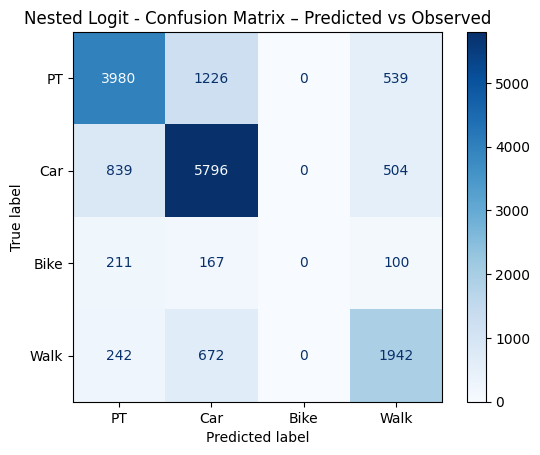


Weighted log-likelihood: -11604.894
Average weighted log-likelihood per obs: -0.7156


In [105]:
import matplotlib.pyplot as plt
# ---------------------------------------------------------------
# Accuracy and confusion matrix (weighted)
# ---------------------------------------------------------------
pred_choice = predicted_probs.idxmax(axis=1).map({'Prob_PT':0,'Prob_Car':1,'Prob_Bike':2, 'Prob_Walk':3})
acc = (w * (pred_choice.values == test_df['travel_mode'].values)).sum() / w_sum
print(f"\nPrediction accuracy (weighted if applicable): {acc:.3f}")

cm = confusion_matrix(test_df['travel_mode'], pred_choice, labels=[0,1,2,3], sample_weight=w)
disp = ConfusionMatrixDisplay(cm, display_labels=['PT','Car','Bike', 'Walk'])
disp.plot(cmap='Blues', values_format='.0f')
plt.title("Nested Logit - Confusion Matrix – Predicted vs Observed")
plt.show()

# ---------------------------------------------------------------
# Weighted log-likelihood
# ---------------------------------------------------------------
choice_to_col = {0:'Prob_PT', 1:'Prob_Car', 2:'Prob_Bike', 3:'Prob_Walk'}
cols = test_df['travel_mode'].map(choice_to_col).to_numpy()
prob_chosen = predicted_probs.to_numpy()[
    np.arange(len(test_df)),
    predicted_probs.columns.get_indexer(cols)
]
prob_chosen = np.clip(prob_chosen, 1e-300, 1)
LL = np.sum(w * np.log(prob_chosen))
avg_LL = LL / w_sum
print(f"\nWeighted log-likelihood: {LL:.3f}")
print(f"Average weighted log-likelihood per obs: {avg_LL:.4f}")


## 8. F1 Score Analysis

Calculate F1 scores to assess classification performance:
- Per-mode F1 scores
- Macro, weighted, and micro averages
- Detailed classification report with precision and recall

In [106]:
from sklearn.metrics import f1_score, classification_report

# ---------------------------------------------------------------
# F1 Scores per mode and overall
# ---------------------------------------------------------------
print("\n" + "="*60)
print("F1 SCORE ANALYSIS")
print("="*60)

# Get predicted choices
pred_choice = predicted_probs.idxmax(axis=1).map({'Prob_PT':0,'Prob_Car':1,'Prob_Bike':2, 'Prob_Walk':3})
true_choice = test_df['travel_mode'].values

# Calculate F1 scores per mode
mode_labels = ['PT', 'Car', 'Bike', 'Walk']
f1_per_mode = f1_score(true_choice, pred_choice, labels=[0, 1, 2, 3], average=None, sample_weight=w)

print("\nF1 Score per Mode:")
for i, mode in enumerate(mode_labels):
    print(f"  {mode:6s}: {f1_per_mode[i]:.4f}")

# Overall F1 scores (different averaging methods)
f1_macro = f1_score(true_choice, pred_choice, labels=[0, 1, 2, 3], average='macro', sample_weight=w)
f1_weighted = f1_score(true_choice, pred_choice, labels=[0, 1, 2, 3], average='weighted', sample_weight=w)
f1_micro = f1_score(true_choice, pred_choice, labels=[0, 1, 2, 3], average='micro', sample_weight=w)

print("\nOverall F1 Scores:")
print(f"  Macro Average    : {f1_macro:.4f}  (unweighted mean of per-class F1)")
print(f"  Weighted Average : {f1_weighted:.4f}  (weighted by class support)")
print(f"  Micro Average    : {f1_micro:.4f}  (equivalent to accuracy)")

# Detailed classification report
print("\n" + "-"*60)
print("DETAILED CLASSIFICATION REPORT")
print("-"*60)
print(classification_report(true_choice, pred_choice, 
                          target_names=mode_labels, 
                          labels=[0, 1, 2, 3],
                          sample_weight=w,
                          digits=4))


F1 SCORE ANALYSIS

F1 Score per Mode:
  PT    : 0.7225
  Car   : 0.7728
  Bike  : 0.0000
  Walk  : 0.6538

Overall F1 Scores:
  Macro Average    : 0.5373  (unweighted mean of per-class F1)
  Weighted Average : 0.7112  (weighted by class support)
  Micro Average    : 0.7225  (equivalent to accuracy)

------------------------------------------------------------
DETAILED CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

          PT     0.7549    0.6928    0.7225    5745.0
         Car     0.7373    0.8119    0.7728    7139.0
        Bike     0.0000    0.0000    0.0000     478.0
        Walk     0.6295    0.6800    0.6538    2856.0

    accuracy                         0.7225   16218.0
   macro avg     0.5304    0.5462    0.5373   16218.0
weighted avg     0.7028    0.7225    0.7112   16218.0



C:\Users\crist\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\crist\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\crist\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

## 9. Direct Elasticity Analysis

Calculate direct elasticities for key variables:
- **PT mode**: Cost, vehicle time, walking time, waiting time, transfers, age effects
- **Car mode**: Time, cost, traffic, socio-demographic effects
- **Bike & Walk modes**: Time elasticities

Elasticity formula: $E = \beta \cdot x \cdot (1 - P)$ where P is the choice probability.

In [107]:
# ---------------------------------------------------------------
# Calculate elasticities for each mode and attribute
# ---------------------------------------------------------------

# Define the estimated beta values and their corresponding variables
beta_values = {
    'B_TIME': betas['B_TIME'],
    'B_COST': betas['B_COST'], 
    'B_TRAFFIC': betas['B_TRAFFIC'],
    'B_VEH_TIME': betas['B_VEH_TIME'],
    'B_WALK_TIME': betas['B_WALK_TIME'],
    'B_WAIT_TIME': betas['B_WAIT_TIME'],
    'B_TRANSFERS': betas['B_TRANSFERS'],
    'B_AGE_18_34': betas['B_AGE_18_34'],
    'B_AGE_35_54': betas['B_AGE_35_54'],
    'B_FEMALE': betas['B_FEMALE'],
    'B_N_HOUSEHOLD_2_5': betas['B_N_HOUSEHOLD_2_5']
}

# Create elasticity results dataframe
elasticity_results = []

# For each mode
modes = ['PT', 'Car', 'Bike', 'Walk']
mode_cols = ['Prob_PT', 'Prob_Car', 'Prob_Bike', 'Prob_Walk']

for i, mode in enumerate(modes):
    mode_probs = predicted_probs[mode_cols[i]]
    
    if mode == 'PT':        
        # Cost elasticity
        pt_cost_elast = beta_values['B_COST'] * test_df['cost_transit'] * (1 - mode_probs)
        elasticity_results.append({
            'Mode': mode, 'Variable': 'Cost', 'Direct_Elasticity': pt_cost_elast.mean()
        })
        
        # Vehicle time elasticity
        pt_veh_time = test_df['dur_pt_rail'] + test_df['dur_pt_bus']
        pt_veh_elast = beta_values['B_VEH_TIME'] * pt_veh_time * (1 - mode_probs)
        elasticity_results.append({
            'Mode': mode, 'Variable': 'Vehicle_Time', 'Direct_Elasticity': pt_veh_elast.mean()
        })
        
        # Walking time elasticity
        pt_walk_time = test_df['dur_pt_access'] + test_df['dur_pt_int_walking']
        pt_walk_elast = beta_values['B_WALK_TIME'] * pt_walk_time * (1 - mode_probs)
        elasticity_results.append({
            'Mode': mode, 'Variable': 'Walking_Time', 'Direct_Elasticity': pt_walk_elast.mean()
        })
        
        # Wait time elasticity
        pt_wait_elast = beta_values['B_WAIT_TIME'] * test_df['dur_pt_int_waiting'] * (1 - mode_probs)
        elasticity_results.append({
            'Mode': mode, 'Variable': 'Wait_Time', 'Direct_Elasticity': pt_wait_elast.mean()
        })
        
        # Transfers elasticity
        pt_trans_elast = beta_values['B_TRANSFERS'] * test_df['pt_n_interchanges'] * (1 - mode_probs)
        elasticity_results.append({
            'Mode': mode, 'Variable': 'Transfers', 'Direct_Elasticity': pt_trans_elast.mean()
        })
        
        # Age 18-34 elasticity
        pt_age_18_34_elast = beta_values['B_AGE_18_34'] * test_df['age_18_34'] * (1 - mode_probs)
        elasticity_results.append({
            'Mode': mode, 'Variable': 'Age_18_34', 'Direct_Elasticity': pt_age_18_34_elast.mean()
        })
        
    elif mode == 'Car':
        # Car elasticities
        # Time elasticity
        car_time_elast = beta_values['B_TIME'] * test_df['dur_driving'] * (1 - mode_probs)
        elasticity_results.append({
            'Mode': mode, 'Variable': 'Time', 'Direct_Elasticity': car_time_elast.mean()
        })
        
        # Cost elasticity
        car_cost_elast = beta_values['B_COST'] * test_df['cost_driving_total'] * (1 - mode_probs)
        elasticity_results.append({
            'Mode': mode, 'Variable': 'Cost', 'Direct_Elasticity': car_cost_elast.mean()
        })
        
        # Traffic elasticity
        car_traffic_elast = beta_values['B_TRAFFIC'] * test_df['driving_traffic_percent'] * (1 - mode_probs)
        elasticity_results.append({
            'Mode': mode, 'Variable': 'Traffic_Percent', 'Direct_Elasticity': car_traffic_elast.mean()
        })
        
        # Age 35-54 elasticity
        car_age_35_54_elast = beta_values['B_AGE_35_54'] * test_df['age_35_54'] * (1 - mode_probs)
        elasticity_results.append({
            'Mode': mode, 'Variable': 'Age_35_54', 'Direct_Elasticity': car_age_35_54_elast.mean()
        })
        
        # Female elasticity
        car_female_elast = beta_values['B_FEMALE'] * test_df['female'] * (1 - mode_probs)
        elasticity_results.append({
            'Mode': mode, 'Variable': 'Female', 'Direct_Elasticity': car_female_elast.mean()
        })
        
        # Household size elasticities
        car_hh_2_5_elast = beta_values['B_N_HOUSEHOLD_2_5'] * test_df['n_household_2_5'] * (1 - mode_probs)
        elasticity_results.append({
            'Mode': mode, 'Variable': 'Household_2_5', 'Direct_Elasticity': car_hh_2_5_elast.mean()
        })
        
    elif mode == 'Bike':
        # Bike elasticity (only time)
        bike_time_elast = beta_values['B_TIME'] * test_df['dur_cycling'] * (1 - mode_probs)
        elasticity_results.append({
            'Mode': mode, 'Variable': 'Time', 'Direct_Elasticity': bike_time_elast.mean()
        })
        
    elif mode == 'Walk':
        # Walk elasticity (only time)
        walk_time_elast = beta_values['B_TIME'] * test_df['dur_walking'] * (1 - mode_probs)
        elasticity_results.append({
            'Mode': mode, 'Variable': 'Time', 'Direct_Elasticity': walk_time_elast.mean()
        })

# Convert to DataFrame and display
elasticity_df = pd.DataFrame(elasticity_results)
print("Direct Elasticities by Mode and Variable:")
print(elasticity_df.round(3))

# Summary by mode
print("\n" + "="*50)
print("ELASTICITY SUMMARY")
print("="*50)
for mode in modes:
    mode_elast = elasticity_df[elasticity_df['Mode'] == mode]
    print(f"\n{mode} Mode:")
    for _, row in mode_elast.iterrows():
        print(f"  {row['Variable']:15s}: {row['Direct_Elasticity']:7.3f}")

Direct Elasticities by Mode and Variable:
    Mode         Variable  Direct_Elasticity
0     PT             Cost             -0.131
1     PT     Vehicle_Time             -0.324
2     PT     Walking_Time             -0.491
3     PT        Wait_Time             -0.074
4     PT        Transfers             -0.010
5     PT        Age_18_34              0.011
6    Car             Time             -0.854
7    Car             Cost             -0.219
8    Car  Traffic_Percent             -0.546
9    Car        Age_35_54             -0.007
10   Car           Female              0.013
11   Car    Household_2_5             -0.116
12  Bike             Time             -1.748
13  Walk             Time             -5.360

ELASTICITY SUMMARY

PT Mode:
  Cost           :  -0.131
  Vehicle_Time   :  -0.324
  Walking_Time   :  -0.491
  Wait_Time      :  -0.074
  Transfers      :  -0.010
  Age_18_34      :   0.011

Car Mode:
  Time           :  -0.854
  Cost           :  -0.219
  Traffic_Percent:  -0.546

## 10. Policy Scenario Analysis

Simulate various transport policy interventions and measure their impact on mode choice:
- Test different policy scenarios
- Calculate mode shift effects
- Assess elasticities and market share changes

In [132]:
# ---------------------------------------------------------------
# SCENARIO ANALYSIS: Combined Cost and Time Effects on Car Driving
# ---------------------------------------------------------------
# Effect 1 (Cost): Increase driving cost by ±10%, ±20%, ±30%
# Effect 2 (Time): Increase driving time by ±2%, ±5%, ±8% (scaled with cost change)
# ---------------------------------------------------------------

print("\n" + "="*80)
print("COMBINED SCENARIO ANALYSIS: Car Cost + Time Effects")
print("="*80)

# Define scenarios: (cost_change%, time_change%)
scenarios = [
    ('Baseline', 0.00, 0.00),
    # Cost increase scenarios
    ('Cost +10% / Time +2%', 0.10, 0.02),
    ('Cost +20% / Time +5%', 0.20, 0.05),
    ('Cost +30% / Time +8%', 0.30, 0.08),
]

results_scenarios = []

for scenario_name, cost_change, time_change in scenarios:
    # Create a copy of test data with modified cost and time
    test_df_scen = test_df.copy()
    test_df_scen['cost_driving_total'] = test_df_scen['cost_driving_total'] * (1 + cost_change)
    test_df_scen['dur_driving'] = test_df_scen['dur_driving'] * (1 + time_change)
    
    # Create new database for the scenario
    database_scen = db.Database(f'scenario_{scenario_name}', test_df_scen)
    database_scen.weights = database_scen.variables['__weight__']
    
    # Define variables for scenario
    choice_scen = database_scen.variables['travel_mode']
    dur_walking_scen = database_scen.variables['dur_walking']
    dur_cycling_scen = database_scen.variables['dur_cycling']
    dur_pt_total_scen = database_scen.variables['dur_pt_total']
    dur_driving_scen = database_scen.variables['dur_driving']
    c_transit_scen = database_scen.variables['cost_transit']
    c_driving_total_scen = database_scen.variables['cost_driving_total']
    driving_traffic_percent_scen = database_scen.variables['driving_traffic_percent']
    pt_n_interchanges_scen = database_scen.variables['pt_n_interchanges']
    dur_pt_rail_scen = database_scen.variables['dur_pt_rail']
    dur_pt_bus_scen = database_scen.variables['dur_pt_bus']
    dur_pt_access_scen = database_scen.variables['dur_pt_access']
    dur_pt_int_walking_scen = database_scen.variables['dur_pt_int_walking']
    dur_pt_int_waiting_scen = database_scen.variables['dur_pt_int_waiting']
    age_18_34_scen = database_scen.variables['age_18_34']
    age_35_54_scen = database_scen.variables['age_35_54']
    age_scen = database_scen.variables['age']
    female_scen = database_scen.variables['female']
    car_ownership_scen = database_scen.variables['car_ownership']
    driving_license_scen = database_scen.variables['driving_license']
    day_of_week_scen = database_scen.variables['day_of_week']
    start_time_linear_scen = database_scen.variables['start_time_linear']
    distance_scen = database_scen.variables['distance']
    n_household_2_5_scen = database_scen.variables['n_household_2_5']
    
    # Reconstruct utilities with modified cost and time
    V0_scen = ASC_PT + B_COST * c_transit_scen + B_VEH_TIME * (dur_pt_rail_scen + dur_pt_bus_scen) + B_WALK_TIME * (dur_pt_access_scen + dur_pt_int_walking_scen) + B_WAIT_TIME * dur_pt_int_waiting_scen + B_TRANSFERS * pt_n_interchanges_scen + B_AGE_18_34 * age_18_34_scen + B_DAY_OF_WEEK_PT * day_of_week_scen
    V1_scen = ASC_CAR + B_TIME * dur_driving_scen + B_COST * c_driving_total_scen + B_COST_X_AGE * c_driving_total_scen * age_scen + B_TRAFFIC * driving_traffic_percent_scen + B_AGE_35_54 * age_35_54_scen + B_FEMALE * female_scen - B_N_HOUSEHOLD_2_5 * n_household_2_5_scen + B_CAR_OWNERSHIP * car_ownership_scen + B_DRIVING_LICENSE * driving_license_scen + B_START_TIME_LINEAR_CAR * start_time_linear_scen + B_DAY_OF_WEEK_CAR * day_of_week_scen
    V2_scen = ASC_BIKE + B_TIME * dur_cycling_scen + B_DISTANCE_CYCLE * distance_scen
    V3_scen = ASC_WALK + B_TIME * dur_walking_scen + B_DISTANCE_WALK * distance_scen
    
    V_scen = {0: V0_scen, 1: V1_scen, 2: V2_scen, 3: V3_scen}
    
    # Simulate probabilities for scenario
    simulate_scen = {
        'Prob_PT': models.logit(V_scen, av, 0),
        'Prob_Car': models.logit(V_scen, av, 1),
        'Prob_Bike': models.logit(V_scen, av, 2),
        'Prob_Walk': models.logit(V_scen, av, 3),
    }
    
    biogeme_scen = bio.BIOGEME(database_scen, simulate_scen)
    
    # Simulate with the same estimated parameters
    predicted_probs_scen = biogeme_scen.simulate(betas)
    
    # Calculate market shares for scenario
    w_scen = test_df_scen['__weight__'].to_numpy()
    w_sum_scen = w_scen.sum()
    
    market_shares_scen = (predicted_probs_scen.mul(w_scen, axis=0).sum() / w_sum_scen)
    
    # Store results
    results_scenarios.append({
        'Scenario': scenario_name,
        'Cost_Change_%': cost_change * 100,
        'Time_Change_%': time_change * 100,
        'Prob_PT': market_shares_scen['Prob_PT'],
        'Prob_Car': market_shares_scen['Prob_Car'],
        'Prob_Bike': market_shares_scen['Prob_Bike'],
        'Prob_Walk': market_shares_scen['Prob_Walk'],
    })

# Create comprehensive results table
results_df = pd.DataFrame(results_scenarios)

print("\n" + "="*80)
print("MARKET SHARE PREDICTIONS ACROSS ALL SCENARIOS")
print("="*80)
print(results_df.to_string(index=False))

# Calculate changes relative to baseline
baseline_shares = {
    'Prob_PT': results_df.iloc[0]['Prob_PT'],
    'Prob_Car': results_df.iloc[0]['Prob_Car'],
    'Prob_Bike': results_df.iloc[0]['Prob_Bike'],
    'Prob_Walk': results_df.iloc[0]['Prob_Walk'],
}


COMBINED SCENARIO ANALYSIS: Car Cost + Time Effects

MARKET SHARE PREDICTIONS ACROSS ALL SCENARIOS
            Scenario  Cost_Change_%  Time_Change_%  Prob_PT  Prob_Car  Prob_Bike  Prob_Walk
            Baseline            0.0            0.0 0.352099  0.442205   0.030314   0.175382
Cost +10% / Time +2%           10.0            2.0 0.356845  0.436478   0.030666   0.176011
Cost +20% / Time +5%           20.0            5.0 0.362851  0.429193   0.031125   0.176832
Cost +30% / Time +8%           30.0            8.0 0.368664  0.422116   0.031578   0.177642


In [137]:
# ---------------------------------------------------------------
# SCENARIO ANALYSIS: PT SERVICE IMPROVEMENTS (COUNTERFACTUAL)
# ---------------------------------------------------------------
# Effect 1 (Time): Reduce PT access/wait time by −10%, −20%, −30%
# Effect 2 (Transfer Penalty): Reduce interchange burden by −10%, −20%, −30%
# ---------------------------------------------------------------

print("\n" + "="*100)
print("PUBLIC TRANSIT SERVICE IMPROVEMENT SCENARIOS (COUNTERFACTUAL)")
print("Effect 1: Reduced Access & Wait Times | Effect 2: Reduced Transfer Penalties")
print("="*100)

# Define baseline using observed data
# Get baseline predictions from test set using estimated parameters
database_baseline = db.Database('baseline', test_df)
database_baseline.weights = database_baseline.variables['__weight__']

# Simulate baseline with estimated parameters
simulate_baseline = {
    'Prob_PT': models.logit(V, av, 0),
    'Prob_Car': models.logit(V, av, 1),
    'Prob_Bike': models.logit(V, av, 2),
    'Prob_Walk': models.logit(V, av, 3),
}

biogeme_baseline = bio.BIOGEME(database_baseline, simulate_baseline)
predicted_probs_baseline = biogeme_baseline.simulate(betas)

# Calculate baseline market shares
w_baseline = test_df['__weight__'].to_numpy()
w_sum_baseline = w_baseline.sum()
baseline_market_share = (predicted_probs_baseline.mul(w_baseline, axis=0).sum() / w_sum_baseline)

print(f"\nBASELINE Market Shares (Observed):")
print(f"  PT:   {baseline_market_share['Prob_PT']:.4f}")
print(f"  Car:  {baseline_market_share['Prob_Car']:.4f}")
print(f"  Bike: {baseline_market_share['Prob_Bike']:.4f}")
print(f"  Walk: {baseline_market_share['Prob_Walk']:.4f}")

# Define PT scenarios: (time_reduction%, transfer_penalty_reduction%)
pt_scenarios = [
    ('PT Access/Wait -10% / Transfer Penalty -10%', -0.10, -0.10),
    ('PT Access/Wait -20% / Transfer Penalty -20%', -0.20, -0.20),
    ('PT Access/Wait -30% / Transfer Penalty -30%', -0.30, -0.30),
]

pt_results_scenarios = []

print(f"\n" + "="*100)
print("COUNTERFACTUAL PT SERVICE IMPROVEMENT SCENARIOS")
print("="*100)

for scenario_name, time_reduction, transfer_reduction in pt_scenarios:
    print(f"\n{scenario_name}")
    print("-" * 100)
    
    # Create scenario data with reduced PT times and transfer penalties
    test_df_scen = test_df.copy()
    
    # Effect 1: Reduce PT access and waiting times
    test_df_scen['dur_pt_access'] = test_df_scen['dur_pt_access'] * (1 + time_reduction)
    test_df_scen['dur_pt_int_waiting'] = test_df_scen['dur_pt_int_waiting'] * (1 + time_reduction)
    
    # Effect 2: Reduce transfer penalty index
    test_df_scen['pt_penalty_index'] = test_df_scen['pt_penalty_index'] * (1 + transfer_reduction)
    
    # Create database
    database_scen = db.Database(scenario_name, test_df_scen)
    database_scen.weights = database_scen.variables['__weight__']
    
    # Use pre-built utilities (V0_scen, V1_scen, V2_scen, V3_scen already defined)
    V_scen = {0: V0_scen, 1: V1_scen, 2: V2_scen, 3: V3_scen}
    
    # Simulate counterfactual probabilities
    simulate_scen = {
        'Prob_PT': models.logit(V_scen, av, 0),
        'Prob_Car': models.logit(V_scen, av, 1),
        'Prob_Bike': models.logit(V_scen, av, 2),
        'Prob_Walk': models.logit(V_scen, av, 3),
    }
    
    biogeme_scen = bio.BIOGEME(database_scen, simulate_scen)
    predicted_probs_scen = biogeme_scen.simulate(betas)
    
    # Calculate counterfactual market shares
    w_scen = test_df_scen['__weight__'].to_numpy()
    w_sum_scen = w_scen.sum()
    market_share_scen = (predicted_probs_scen.mul(w_scen, axis=0).sum() / w_sum_scen)
    
    # Store results
    results_scen_row = {
        'Scenario': scenario_name,
        'Prob_PT': market_share_scen['Prob_PT'],
        'Prob_Car': market_share_scen['Prob_Car'],
        'Prob_Bike': market_share_scen['Prob_Bike'],
        'Prob_Walk': market_share_scen['Prob_Walk'],
    }
    pt_results_scenarios.append(results_scen_row)
    
    # Print counterfactual market shares
    print(f"Counterfactual Market Shares:")
    print(f"  PT:   {market_share_scen['Prob_PT']:.4f}")
    print(f"  Car:  {market_share_scen['Prob_Car']:.4f}")
    print(f"  Bike: {market_share_scen['Prob_Bike']:.4f}")
    print(f"  Walk: {market_share_scen['Prob_Walk']:.4f}")

# Display results table
pt_results_df = pd.DataFrame(pt_results_scenarios)

print("\n" + "="*100)
print("SUMMARY TABLE: BASELINE vs COUNTERFACTUAL MARKET SHARES")
print("="*100)

summary_table = pd.DataFrame({
    'Scenario': ['Baseline'] + list(pt_results_df['Scenario']),
    'PT': [baseline_market_share['Prob_PT']] + list(pt_results_df['Prob_PT']),
    'Car': [baseline_market_share['Prob_Car']] + list(pt_results_df['Prob_Car']),
    'Bike': [baseline_market_share['Prob_Bike']] + list(pt_results_df['Prob_Bike']),
    'Walk': [baseline_market_share['Prob_Walk']] + list(pt_results_df['Prob_Walk']),
})

print(summary_table.to_string(index=False))
# Export results to Excel
with pd.ExcelWriter('PT_Service_Improvements_Analysis.xlsx', engine='openpyxl') as writer:
    summary_table.to_excel(writer, sheet_name='Market Shares', index=False)
    pt_results_df.to_excel(writer, sheet_name='Scenario Details', index=False)

print("\n✓ Results exported to 'PT_Service_Improvements_Analysis.xlsx'")


PUBLIC TRANSIT SERVICE IMPROVEMENT SCENARIOS (COUNTERFACTUAL)
Effect 1: Reduced Access & Wait Times | Effect 2: Reduced Transfer Penalties

BASELINE Market Shares (Observed):
  PT:   0.3521
  Car:  0.4422
  Bike: 0.0303
  Walk: 0.1754

COUNTERFACTUAL PT SERVICE IMPROVEMENT SCENARIOS

PT Access/Wait -10% / Transfer Penalty -10%
----------------------------------------------------------------------------------------------------
Counterfactual Market Shares:
  PT:   0.3696
  Car:  0.4286
  Bike: 0.0287
  Walk: 0.1732

PT Access/Wait -20% / Transfer Penalty -20%
----------------------------------------------------------------------------------------------------
Counterfactual Market Shares:
  PT:   0.3873
  Car:  0.4146
  Bike: 0.0271
  Walk: 0.1709

PT Access/Wait -30% / Transfer Penalty -30%
----------------------------------------------------------------------------------------------------
Counterfactual Market Shares:
  PT:   0.4053
  Car:  0.4004
  Bike: 0.0257
  Walk: 0.1686

SUMMAR